In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from sklearn.preprocessing import StandardScaler
import joblib
from transformers import AutoTokenizer, DistilBertForSequenceClassification
#from datasets import Dataset,load_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce MX150


# Load test data

In [46]:
# Get all test data files
fb_path = '../../data/02_processed/finbert_data/test/'
fb_files = [file for file in os.listdir(fb_path) if file.endswith('lemma.csv')]
fb_files

['EarningsPerShareDiluted_test__lemma.csv',
 'EBIT_test__lemma.csv',
 'NetCashProvidedByUsedInFinancingActivities_test__lemma.csv',
 'NetCashProvidedByUsedInInvestingActivities_test__lemma.csv',
 'NetIncomeLoss_test__lemma.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_test__lemma.csv']

In [47]:
# Get all test data files
db_path = '../../data/02_processed/distilbert_data/test/'
db_files = [file for file in os.listdir(db_path) if file.endswith('lemma.csv')]
db_files

['EarningsPerShareDiluted_test__lemma.csv',
 'EBIT_test__lemma.csv',
 'NetCashProvidedByUsedInFinancingActivities_test__lemma.csv',
 'NetCashProvidedByUsedInInvestingActivities_test__lemma.csv',
 'NetIncomeLoss_test__lemma.csv',
 'RevenueFromContractWithCustomerExcludingAssessedTax_test__lemma.csv']

# Evaluate FinBERT regressor

In [8]:
def prepare_labeled_datasets(tokenizer, model, length, texts, labelsset):
  inputs=[]
  labels=[]
  for i in range(len(labelsset)):
    input=torch.tensor([tokenizer.encode(texts[i], padding='max_length',truncation=True, max_length=length)]).to(device) # Apply the tokenizer to get the token ids for each text, transform to tensors and send to GPU device
    label= torch.tensor([labelsset[i]]).to(device) # send the labels to the GPU device
    inputs.append(input)
    labels.append(label)
  inputs=torch.cat(inputs)  # add to the list of tensors
  labels=torch.cat(labels)  
  dataset = TensorDataset(inputs, labels) # Generate a labeled Tensor-Dataset for training
  return dataset

In [10]:
def loss_function(predictions, labels):
    mse_predictions_labels = torch.nn.functional.mse_loss(predictions.view(-1), labels.view(-1).float())
    mean_labels = torch.mean(labels.float())
    mse_labels_mean = torch.nn.functional.mse_loss(labels.view(-1).float(), mean_labels.expand_as(labels).view(-1))
    rse = mse_predictions_labels / mse_labels_mean
    return rse

In [11]:
def evaluate(model, tokenizer, length, texts, labelsset):
    # Scale the labels
    
    # Create the TensorDataset
    dataset=prepare_labeled_datasets(tokenizer, model, length, texts, labelsset)
    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=32) # Generate a DataLoader for the Tensor-Dataset
    
    model.eval() # Set the model to evaluation mode
    total_loss = 0
    total_predictions = []
    total_labels = []
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch) # Send the batch to the GPU device
        b_input_ids, b_labels = batch # Unpack the batch
        with torch.no_grad(): 
            outputs = model(b_input_ids) # Forward pass
            predictions = outputs[0] # Get the predictions
            loss = loss_function(predictions, b_labels) # Compute the loss
            total_loss += loss.item() # Accumulate the loss
            total_predictions.append(predictions.cpu().numpy()) # Accumulate the predictions
            total_labels.append(b_labels.cpu().numpy()) # Accumulate the labels
    avg_loss = total_loss / len(dataloader) # Compute the average loss
    total_predictions = np.concatenate(total_predictions, axis=0) # Concatenate the predictions
    total_labels = np.concatenate(total_labels, axis=0) # Concatenate the labels
    return avg_loss, total_predictions, total_labels

In [13]:
# Function to load the model and scaler 
def load_data_model_and_scaler(file_path, file_name, hub_path, scaler_path):
    # Load data 
    data = pd.read_csv(file_path + file_name)
    
    # Load model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained(hub_path).to(device)
    tokenizer = AutoTokenizer.from_pretrained(hub_path)
    
    # Load scaler to inverse transform the predicted values
    scaler = joblib.load(open(scaler_path, 'rb'))
    return data, model, tokenizer, scaler 

In [35]:
# Rename the metrics into notations
metric_map = {'EBIT':'EBIT',
            'EarningsPerShareDiluted': 'EPS',
            'NetIncomeLoss': 'INCOME',
            'NetCashProvidedByUsedInFinancingActivities':'FCF',
            'RevenueFromContractWithCustomerExcludingAssessedTax':'REV',
            'NetCashProvidedByUsedInInvestingActivities':'ICF'
            }

## FinBERT data

,Metric,RSE
0,EBIT,1.16
1,EPS,0.83
3,FCF,1.52
5,ICF,1.22
2,INCOME,0.72
4,REV,0.58


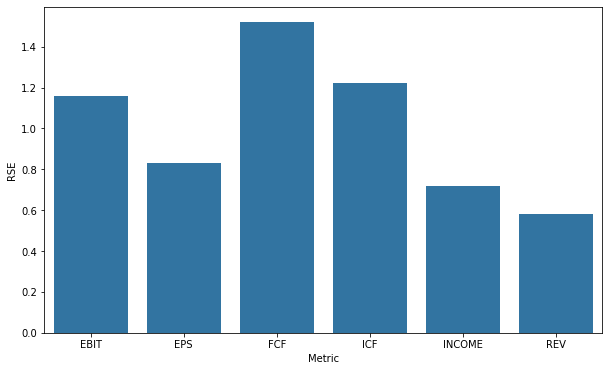

In [37]:
results = []
for i in range(len(fb_files)):
    file = fb_files[i]
    metric_name = file.split('.')[0].split('_')[0]
    #metric_list.append(metric_name)
    
    
    #print(f"--------------EVALUATING FINBERT REGRESSION MODEL OF {metric_name}--------------")
    
    # Specify the paths to load the data, model and scaler 
    hub_path = 'lenguyen/' + 'finbert_' + metric_name
    scaler_path = '../../models/finbert-regression/finbert_data/' + metric_name + '_scaler.pkl'
    scaler = joblib.load(open(scaler_path, 'rb'))
    
    # Load the data, model and tokenizer
    data, model, tokenizer, scaler = load_data_model_and_scaler(fb_path, file, hub_path, scaler_path)
    
    # Scale the target variable
    data['target'] = scaler.transform(data['target'].values.reshape(-1,1))
    
    # Evaluate the model
    avg_loss, _, _ = evaluate(model, tokenizer, 300, data['text'].values.tolist(), 
                                            data['target'].values.tolist())

    #loss_list.append(avg_loss)
    
    # Print a DataFrame of the results
    results.append({
        'Metric': metric_name,
        'RSE': avg_loss
            }) 
result_df = pd.DataFrame(results)
result_df['Metric'] = result_df['Metric'].map(metric_map) # Remap the Metric column to the notations
result_df['RSE'] = result_df['RSE'].round(2)
result_df = result_df.sort_values(by='Metric')

result_df.to_csv('../../results/evaluation/finbert_regression_results__finbert.csv', index=False)

# Plot the results
plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='RSE', data=result_df)

# Show the results in table form
result_df

## DistilBERT data

Error lenguyen/distilbert_NetCashProvidedByUsedInFinancingActivities is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>` found. Skipping...


,Metric,RSE
0,EBIT,1.33
1,EPS,0.91
3,FCF,NaN
5,ICF,1.02
2,INCOME,0.82
4,REV,0.65


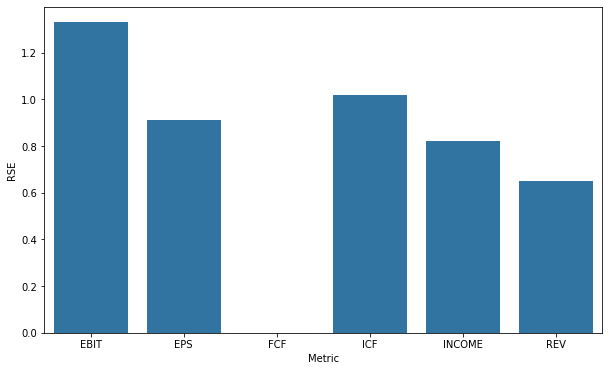

In [55]:
db_results = []
for i in range(len(db_files)):
    file = db_files[i]
    metric_name = file.split('.')[0].split('_')[0]
    #metric_list.append(metric_name)
    
    
    #print(f"--------------EVALUATING FINBERT REGRESSION MODEL OF {metric_name}--------------")
    
    # Specify the paths to load the data, model and scaler 
    hub_path = 'lenguyen/' + 'distilbert_' + metric_name
    scaler_path = '../../models/finbert-regression/distilbert_data/' + metric_name + '_scaler.pkl'
    try:
        if os.path.exists(scaler_path):
            # Load scaler if file exists
            scaler = joblib.load(open(scaler_path, 'rb'))
        
        # Load the data, model and tokenizer
        data, model, tokenizer, scaler = load_data_model_and_scaler(db_path, file, hub_path, scaler_path)
        
        # Scale the target variable
        data['target'] = scaler.transform(data['target'].values.reshape(-1,1))
        
        # Evaluate the model
        avg_loss, _, _ = evaluate(model, tokenizer, 300, data['text'].values.tolist(), 
                                                data['target'].values.tolist())

        #loss_list.append(avg_loss)
        
        # Print a DataFrame of the results
        db_results.append({
            'Metric': metric_name,
            'RSE': avg_loss
                }) 
    except Exception as e:
        print(f"Error {e} found. Skipping...")
        db_results.append({
            'Metric': metric_name,
            'RSE': np.nan
                }) 
        pass
db_result_df = pd.DataFrame(db_results)
db_result_df['Metric'] = db_result_df['Metric'].map(metric_map) # Remap the Metric column to the notations
db_result_df['RSE'] = db_result_df['RSE'].round(2)
db_result_df = db_result_df.sort_values(by='Metric')

db_result_df.to_csv('../../results/evaluation/finbert_regression_results__distilbert.csv', index=False)

# Plot the results
plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='RSE', data=db_result_df)

# Show the results in table form
db_result_df

# Evaluate Random forest regressor

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle

In [8]:
# Load models of DistilBERT
db_model_path = '../../models/random_forest/distilbert_data/'
db_models = [file for file in os.listdir(db_model_path) if file.endswith('.pkl')]  
print(db_models)

# Load models of FinBERT
fb_model_path = '../../models/random_forest/finbert_data/'
fb_models = [file for file in os.listdir(fb_model_path) if file.endswith('.pkl')]
print(fb_models)

['EarningsPerShareDiluted_TF-IDF.pkl', 'EBIT_TF-IDF.pkl', 'NetCashProvidedByUsedInFinancingActivities_TF-IDF.pkl', 'NetCashProvidedByUsedInInvestingActivities_TF-IDF.pkl', 'NetIncomeLoss_TF-IDF.pkl', 'RevenueFromContractWithCustomerExcludingAssessedTax_TF-IDF.pkl']
['EarningsPerShareDiluted_TF-IDF.pkl', 'EBIT_TF-IDF.pkl', 'NetCashProvidedByUsedInFinancingActivities_TF-IDF.pkl', 'NetCashProvidedByUsedInInvestingActivities_TF-IDF.pkl', 'NetIncomeLoss_TF-IDF.pkl', 'RevenueFromContractWithCustomerExcludingAssessedTax_TF-IDF.pkl']


In [11]:
 # Define the RSE scoring function
def rse_scorer(y_true, y_pred):
    true_mean = np.mean(y_true)
    squared_error_num = np.sum(np.square(y_true - y_pred))
    squared_error_den = np.sum(np.square(y_true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return -rse_loss  # Note the negative sign since GridSearchCV maximizes the score

In [9]:
# Load model from pickle file
def load_data_and_model(file_path, file_name, model_path, model_name):
    # Load data
    data = pd.read_csv(file_path + file_name)
    
    # Load model
    model = pickle.load(open(model_path + model_name, 'rb'))
    return data, model

In [12]:
data, model = load_data_and_model(db_path, db_files[0], db_model_path, db_models[0])
model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.95,
                                                        min_df=18)),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 4, 8],
                         'rf__max_features': [1.0, 'sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 5, 10],
                         'rf__min_samples_split': [2, 10, 20],
                         'rf__n_estimators': [100, 200, 500]},
             scoring=make_scorer(rse_scorer))

In [32]:
db_files[0]

'EarningsPerShareDiluted_test__lemma.csv'

In [26]:
def evaluate_rf_model(data, model):
    # Make predictions
    predictions = model.predict(data['text'].values.tolist())
 
    # Compute the loss
    true_mean = np.mean(data['target'])
    squared_error_num = np.sum(np.square(data['target'] - predictions))
    squared_error_den = np.sum(np.square(data['target'] - true_mean))
    loss = squared_error_num / squared_error_den
    return loss

In [33]:
def show_results(results):
    result_df = pd.DataFrame(results)
    result_df['Metric'] = result_df['Metric'].map(metric_map) # Remap the Metric column to the notations
    result_df['RSE'] = result_df['RSE'].round(2)
    result_df = result_df.sort_values(by='Metric')
    
    # Plot the results
    plt.figure(figsize=(10,6))
    sns.barplot(x='Metric', y='RSE', data=result_df)
    return result_df

## DistilBERT data

,Metric,RSE
1,EBIT,0.02
0,EPS,0.83
2,FCF,0.37
3,ICF,0.83
4,INCOME,0.57
5,REV,0.41


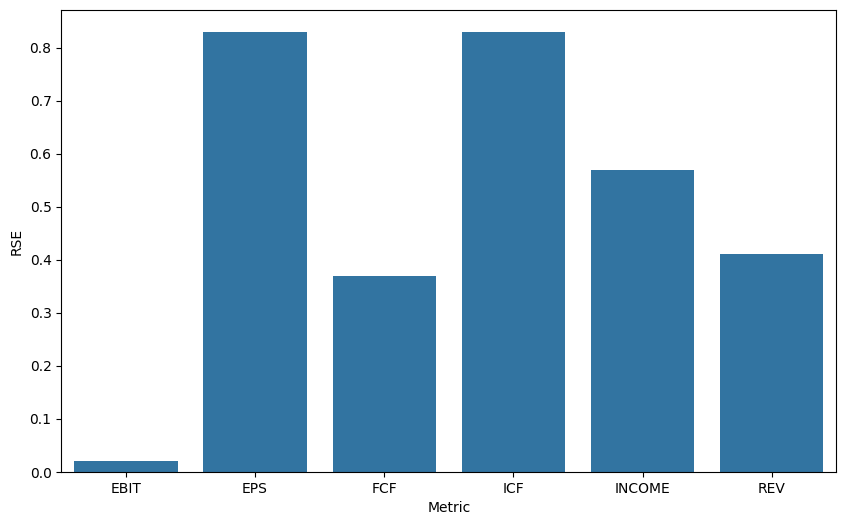

In [36]:
# Calculate the RSE loss for each model
db_rf_results = []
for i in range(len(db_models)):
    file = db_files[i]
    metric_name = file.split('.')[0].split('_')[0]
    
    # Specify the paths to load the data, model and scaler 
    model_path = db_model_path
    model_name = db_models[i]
    
    # Load the data, model and tokenizer
    data, model = load_data_and_model(db_path, file, model_path, model_name)
    
    # Evaluate the model
    loss = evaluate_rf_model(data, model)
    
    # Print a DataFrame of the results
    db_rf_results.append({
        'Metric': metric_name,
        'RSE': loss
            })
db_rf_result_df = show_results(db_rf_results)

# Save results
db_rf_result_df.to_csv('../../results/evaluation/random_forest_results__distilbert.csv', index=False)

# Show the results in table form
db_rf_result_df

## FinBERT data

,Metric,RSE
1,EBIT,0.13
0,EPS,0.77
2,FCF,0.20
3,ICF,0.75
4,INCOME,0.58
5,REV,0.39


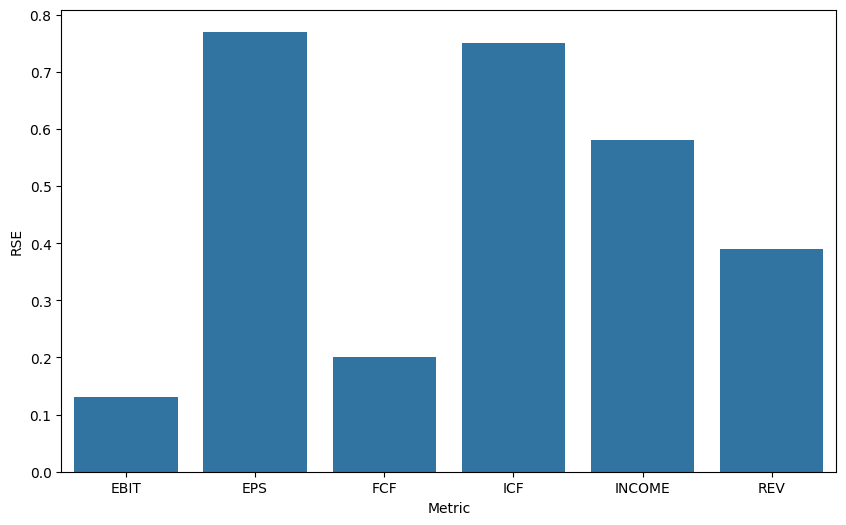

In [37]:
fb_rf_results = []
for i in range(len(fb_models)):
    file = fb_files[i]
    metric_name = file.split('.')[0].split('_')[0]
    
    # Specify the paths to load the data, model and scaler 
    model_path = fb_model_path
    model_name = fb_models[i]
    
    # Load the data, model and tokenizer
    data, model = load_data_and_model(fb_path, file, model_path, model_name)
    
    # Evaluate the model
    loss = evaluate_rf_model(data, model)
    
    # Print a DataFrame of the results
    fb_rf_results.append({
        'Metric': metric_name,
        'RSE': loss
            })
fb_rf_result_df = show_results(fb_rf_results)

# Save results
fb_rf_result_df.to_csv('../../results/evaluation/random_forest_results__finbert.csv', index=False)

# Show the results in table form
fb_rf_result_df

# Check data size

In [52]:
for i in range(len(db_files)):
    metric_name = db_files[i].split('.')[0].split('_')[0]
    data = pd.read_csv(db_path + db_files[i])
    data_len = len(data)
    print(f'{metric_name}: {data_len}')    

EarningsPerShareDiluted: 89
EBIT: 41
NetCashProvidedByUsedInFinancingActivities: 5
NetCashProvidedByUsedInInvestingActivities: 8
NetIncomeLoss: 2275
RevenueFromContractWithCustomerExcludingAssessedTax: 1576


In [53]:
for i in range(len(fb_files)):
    metric_name = fb_files[i].split('.')[0].split('_')[0]
    data = pd.read_csv(fb_path + fb_files[i])
    data_len = len(data)
    print(f'{metric_name}: {data_len}')    

EarningsPerShareDiluted: 88
EBIT: 36
NetCashProvidedByUsedInFinancingActivities: 5
NetCashProvidedByUsedInInvestingActivities: 8
NetIncomeLoss: 2300
RevenueFromContractWithCustomerExcludingAssessedTax: 1572
